Exercise 59

In [31]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_dense_adj
from torch_geometric.nn import MessagePassing
from torch_geometric.nn.aggr import SumAggregation

5.1 Graphs

This exercise is about setting up some graphs and getting accustomed to manipulate them. There will be no messages sent, and no trainable parameters on the graphs in this exercise.

5.2 Some graphs

This helper function provides you with edge indices, random node positions, and node values for graphs with all nodes interconnected to each other. num_nodes is the number of nodes in the graph.



In [ ]:
def elements_for_random_graph(num_nodes):
    cutoff = 2.5

    box_size=10
    positions = []
    for i in range(num_nodes):
        new_position = torch.rand(1, 2) * box_size
        if len(positions) > 0:
            all_positions = torch.vstack(positions)
            while torch.any(torch.cdist(all_positions, new_position) < 0.75*cutoff) or \
            torch.all(torch.cdist(all_positions, new_position) > cutoff):
                new_position = torch.rand(1, 2) * box_size        
        positions.append(new_position)

    positions = torch.vstack(positions)

    edge_index = []
    for i in range(len(positions)):
        for j in range(len(positions)):
            edge_index.append([i, j])

    edge_index = torch.tensor(np.array(edge_index).T, dtype=torch.int64).reshape(2, -1)
    x = torch.tensor(list(range(num_nodes)),dtype=torch.float32)
    return edge_index, positions, x

a) Call elements_for_random_graph for a 4-node graph

In [49]:
torch.manual_seed(0)
elements = elements_for_random_graph(4)
elements

(tensor([[0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3],
         [0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3]]),
 tensor([[4.9626, 7.6822],
         [3.0742, 6.3408],
         [3.4889, 4.0172],
         [6.9767, 8.0001]]),
 tensor([0., 1., 2., 3.]))

b) Use the output to set up a Torch Geometric graph, graph1.

In [50]:
# Map components from elements
edge_index = elements[0]  # Edge indices (connectivity)
pos = elements[1]         # Random node positions
x = elements[2].unsqueeze(1)  # Node values, reshaped to be compatible as features

# Create the graph data object
graph1 = Data(x=x, edge_index=edge_index, pos=pos)

# Print the graph to verify
print(graph1)

Data(x=[4, 1], edge_index=[2, 16], pos=[4, 2])


c) Repeat b) to get a second Torch Geometric graph, graph2, and plot the two graphs with some code that you write.

In [51]:
torch.manual_seed(1)
elements = elements_for_random_graph(4)
elements

(tensor([[0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3],
         [0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3]]),
 tensor([[7.5763, 2.7931],
         [5.6951, 4.3878],
         [4.1619, 2.8433],
         [3.3978, 5.2394]]),
 tensor([0., 1., 2., 3.]))

In [52]:
# Map components from elements
edge_index = elements[0]  # Edge indices (connectivity)
pos = elements[1]         # Random node positions
x = elements[2].unsqueeze(1)  # Node values, reshaped to be compatible as features

# Create the graph data object
graph2 = Data(x=x, edge_index=edge_index, pos=pos)

# Print the graph to verify
print(graph2)

Data(x=[4, 1], edge_index=[2, 16], pos=[4, 2])


In [53]:
def plot_graph(ax, graph):

    # Plot the nodes:
    for idx, pos in enumerate(graph.pos):
        ax.scatter(pos[0], pos[1], c='C1', s=1000)
        ax.text(pos[0], pos[1], f'{idx}', color='w', ha='center', va='center')    
    
    # Plot the edges:
    for idx, (i1,i2) in enumerate(graph.edge_index.T):
        ax.plot([graph.pos[i1,0], graph.pos[i2,0]], [graph.pos[i1,1], graph.pos[i2,1]], c='black', zorder=0)

    ax.axis('equal')

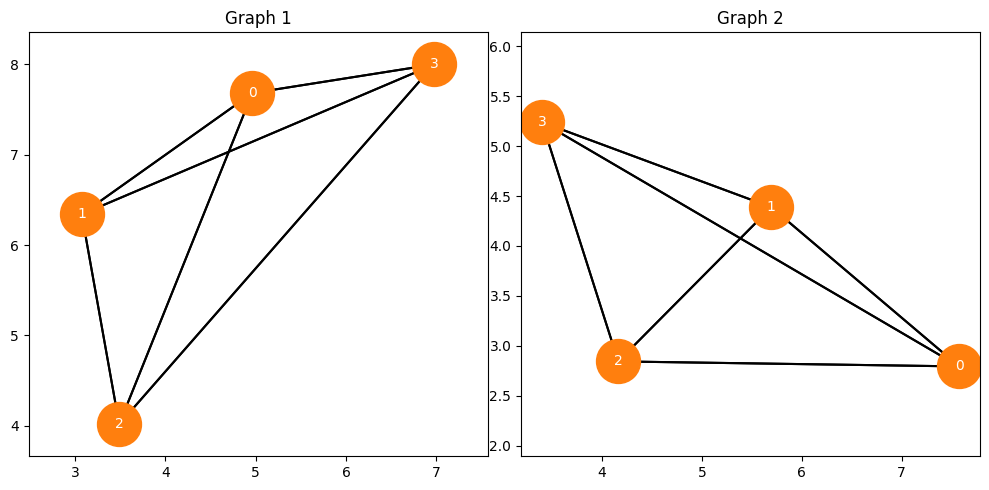

In [56]:
# Define the figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns of subplots

# Plot the first graph
plot_graph(axes[0], graph1)
axes[0].set_title("Graph 1")

# Plot the second graph
plot_graph(axes[1], graph2)
axes[1].set_title("Graph 2")

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


5.3 Similarity of graphs

d) Write a function that will tell if two graphs are most likely identical according to the sorted eigenvalues of the adjacency matrix. Check if graph1 and graph2 are identical.

In [ ]:
# Using the sorted eigenvals of the adjacency matrices, we check if the graphs are probably identical

def graphs_are_identical(graph1, graph2):
    adj_matrix1 = to_dense_adj(graph1.edge_index)
    eig1 = np.linalg.eigvalsh(adj_matrix1)
    sorted_eig1 = np.sort(eig1)

    adj_matrix2 = to_dense_adj(graph2.edge_index)
    eig2 = np.linalg.eigvalsh(adj_matrix2)
    sorted_eig2 = np.sort(eig2)

    are_identical = np.allclose(sorted_eig1, sorted_eig2)
    return are_identical

print(graphs_are_identical(graph1,graph2))

True


e) Write a function that receives the edge_index and positions that you get from elements_for_random_graph and returns a new edge_index that only contains indices for edges that are shorter than 2.5.

In [77]:
def keep_short_edges(edge_index, positions):
    edge_index_to_keep = []
    for edge in edge_index.T:
        source = positions[edge[0]]
        target = positions[edge[1]]
        
        # Compute the Euclidean distance between source and target positions
        distance = torch.norm(source - target)
        
        # Keep the edge if the distance is less than 2.5
        if distance < 2.5:
            edge_index_to_keep.append(edge.tolist())
    
    # Convert the list of edges back to a tensor and transpose to match edge_index format
    return torch.tensor(np.array(edge_index_to_keep).T, dtype=torch.long)


In [78]:
# Example usage
# Assuming elements[0] is edge_index and elements[1] is positions from elements_for_random_graph
edge_index = elements[0]
positions = elements[1]

# Get the filtered edge_index
new_edge_index = keep_short_edges(edge_index, positions)
print(new_edge_index)

tensor([[0, 0, 1, 1, 1, 1, 2, 2, 3, 3],
        [0, 1, 0, 1, 2, 3, 1, 2, 1, 3]])


f) Make a function that first calls elements_for_random_graph, and then calls your function from e), and finally returns a Torch Geometric graph object, where now only edges shorter than 2.5 are retained.

In [ ]:
def random_graph(num_nodes):
    # Call elements_for_random_graph to generate graph components
    edge_index, positions, node_values = elements_for_random_graph(num_nodes)
    
    # Retain only edges shorter than 2.5
    edge_index = keep_short_edges(edge_index, positions)
    
    # Create the PyTorch Geometric graph object
    graph = Data(x=node_values.unsqueeze(1), edge_index=edge_index, pos=positions)
    
    return graph


Data(x=[4, 1], edge_index=[2, 10], pos=[4, 2])


g) Call random_graph twice and plot the two graphs.




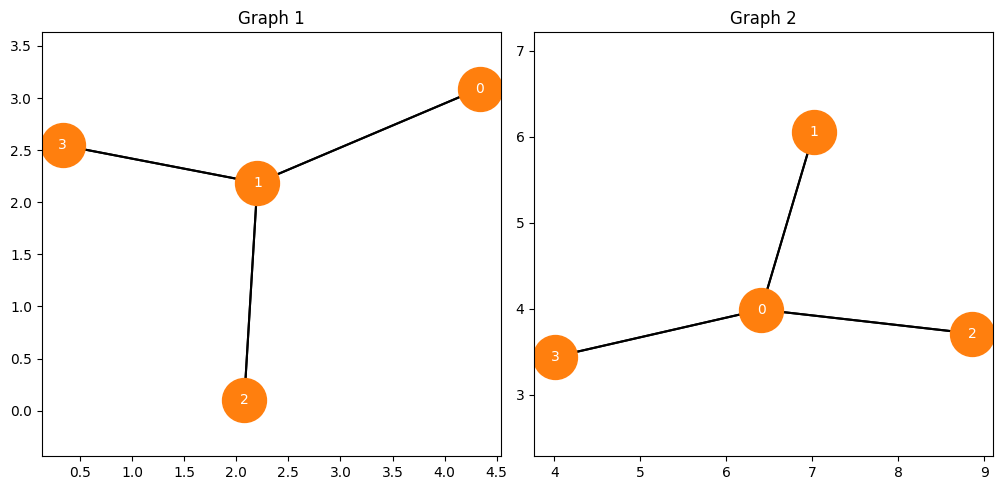

In [83]:
num_nodes = 4
graph1 = random_graph(num_nodes)
graph2 = random_graph(num_nodes)

# Define the figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns of subplots

# Plot the first graph
plot_graph(axes[0], graph1)
axes[0].set_title("Graph 1")

# Plot the second graph
plot_graph(axes[1], graph2)
axes[1].set_title("Graph 2")

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


h) Check if the two graphs are identical according to the criterion involving the sorted eigenvalue spectra.

In [93]:
are_identical = graphs_are_identical(graph1,graph2)
if are_identical:
    print('The two graphs are identical') 
else:
    print('The two graphs are not identical')


The two graphs are identical


i) Create very many random graphs with 5 nodes. Keep those with unique graphs in a list. Plot the graphs eventually. Now many distinct graphs can you find?


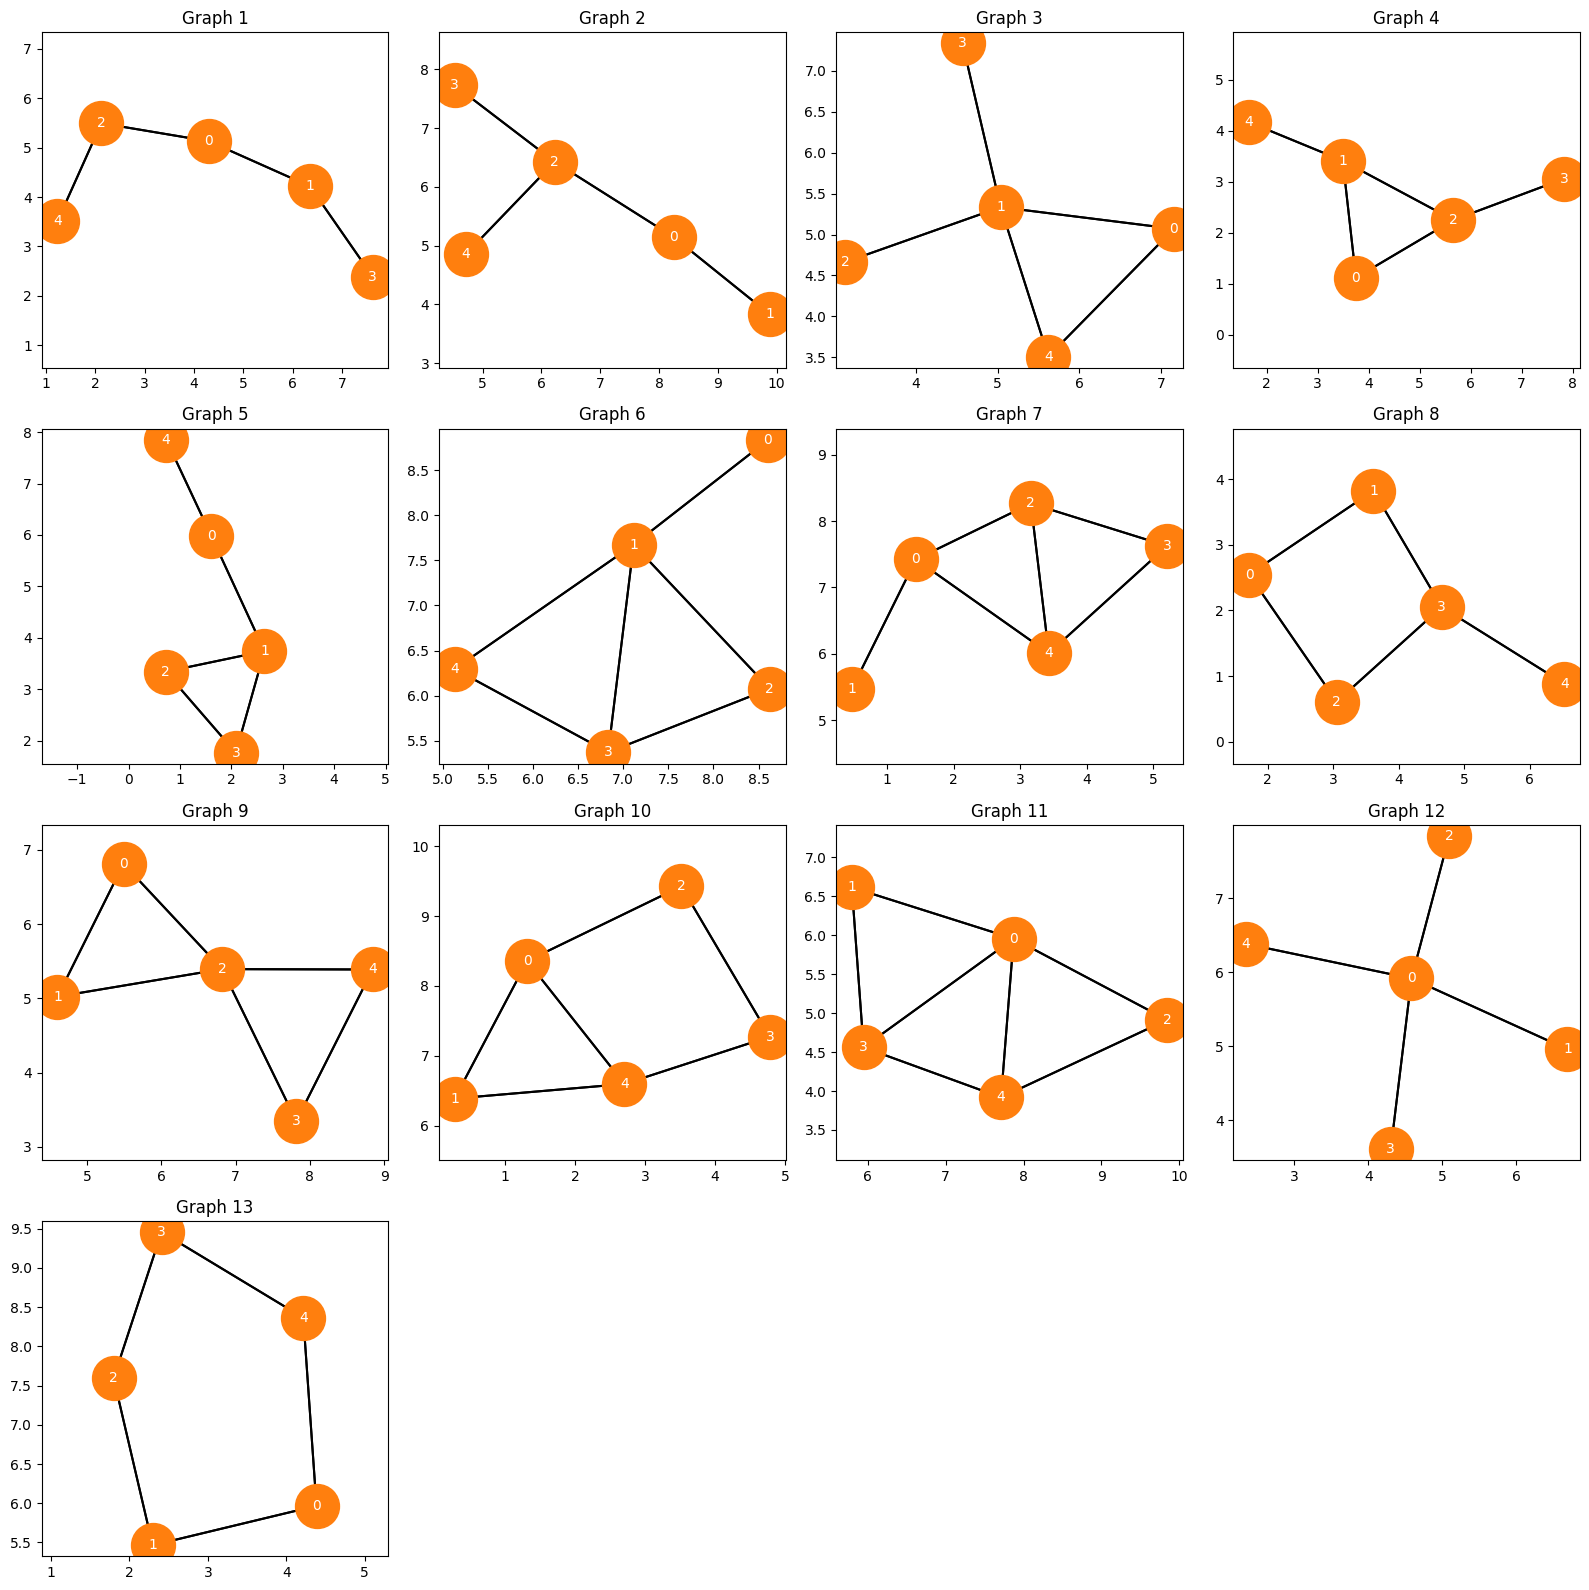

In [ ]:
num_nodes = 5
unique_5_node_graphs = []

# Generate unique graphs
for i in range(500):
    new_graph = random_graph(num_nodes)
    unique = True
    for j in range(len(unique_5_node_graphs)):
        if graphs_are_identical(new_graph, unique_5_node_graphs[j]):
            unique = False
    if unique:
        unique_5_node_graphs.append(new_graph)

# Define the number of rows and columns
num_cols = 4
num_rows = (len(unique_5_node_graphs) + num_cols - 1) // num_cols  # Calculate rows needed

# Define the figure with subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 4, num_rows * 4))

# Flatten axes for easy iteration if there are multiple rows
axes = axes.flatten()

# Plot each unique graph
for k, graph in enumerate(unique_5_node_graphs):
    plot_graph(axes[k], graph)
    axes[k].set_title(f"Graph {k + 1}")

# Hide unused subplots
for k in range(len(unique_5_node_graphs), len(axes)):
    axes[k].axis('off')

plt.tight_layout()
plt.show()


Exercise 60

6.1 Message no self-loops:

Set up this graph:

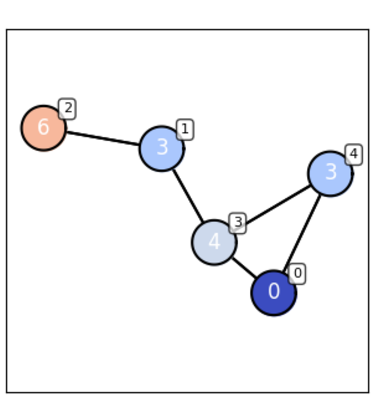

In [115]:
# Node features (attributes written in white inside the nodes)
x = torch.tensor([[0], [3], [6], [3], [4]], dtype=torch.float)  # Each row corresponds to a node

# Edge indices (connections between nodes, as seen in the graph)
edge_index = torch.tensor([
    [0, 1], [1, 0],
    [1, 2], [2, 1],
    [1, 3], [3, 1],
    [0, 3], [3, 0],
    [3, 4], [4, 3]
], dtype=torch.long).t()  # Transpose to get shape [2, num_edges]

# Create the graph
graph = Data(x=x, edge_index=edge_index)

# Print the graph to verify
print(graph)


Data(x=[5, 1], edge_index=[2, 10])


Make a new plotting method that can also plot labels.

In [116]:
def plot_graph_extended(ax, graph):

    # Plot the nodes
    for idx, pos in enumerate(graph.pos):
        # Draw the node as a large circle
        ax.scatter(pos[0], pos[1], c='C1', s=1000)

        # Display the node's attribute value inside the circle
        ax.text(pos[0], pos[1], f'{int(graph.x[idx].item())}', color='w', ha='center', va='center', fontsize=12)

        # Add the node index (label) outside the circle
        ax.text(pos[0] + 0.1, pos[1] + 0.1, f'{idx}', color='black', ha='center', va='center', fontsize=10)
    
    # Plot the edges
    for i1, i2 in graph.edge_index.T:
        ax.plot([graph.pos[i1, 0], graph.pos[i2, 0]], [graph.pos[i1, 1], graph.pos[i2, 1]], c='black', zorder=0)

    # Set equal axis scaling
    ax.axis('equal')


Make a graph with attributes called GraphWithAttributes

In [186]:
class GraphWithAttributes:
    def __init__(self):
        # Initialize node features
        self.x = torch.tensor([[0], [3], [6], [3], [4]], dtype=torch.float)

        # Initialize edge indices
        self.edge_index = torch.tensor([
            [0, 1], [1, 0],
            [1, 2], [2, 1],
            [1, 3], [3, 1],
            [0, 3], [3, 0],
            [3, 4], [4, 3]
        ], dtype=torch.long).t()

        # Initialize node positions
        self.pos = torch.tensor([
            [0.0, 0.0],  # Node 0
            [1.0, 1.0],  # Node 1
            [2.0, 2.0],  # Node 2
            [1.0, 0.0],  # Node 3
            [2.0, 0.0],  # Node 4
        ])

        # Create the PyTorch Geometric graph
        self.graph = Data(x=self.x, edge_index=self.edge_index, pos=self.pos)

    def plot_graph(self, ax=None):
        """
        Plot the graph with extended attributes (node values inside and labels outside).
        """
        if ax is None:
            fig, ax = plt.subplots(figsize=(6, 6))

        # Plot the nodes
        for idx, pos in enumerate(self.graph.pos):
            ax.scatter(pos[0], pos[1], c='C1', s=1000)  # Draw the nodes
            ax.text(pos[0], pos[1], f'{int(self.graph.x[idx].item())}', color='w', ha='center', va='center')  # Node values
            ax.text(pos[0] + 0.1, pos[1] + 0.1, f'{idx}', color='black', ha='center', va='center')  # Node indices
        
        # Plot the edges
        for i1, i2 in self.graph.edge_index.T:
            ax.plot([self.graph.pos[i1, 0], self.graph.pos[i2, 0]], 
                    [self.graph.pos[i1, 1], self.graph.pos[i2, 1]], c='black', zorder=0)

        ax.axis('equal')
        ax.set_title("Graph Visualization")

    def add_self_loops(self):
        """
        Add self-loops to the graph.
        """
        from torch_geometric.utils import add_self_loops
        self.graph.edge_index, _ = add_self_loops(self.graph.edge_index)

    def print_graph(self):
        """
        Print the graph structure.
        """
        print("Graph Data:")
        print(self.graph)


Show the graph_w_attributes as a plot.

Graph Data:
Data(x=[5, 1], edge_index=[2, 10], pos=[5, 2])


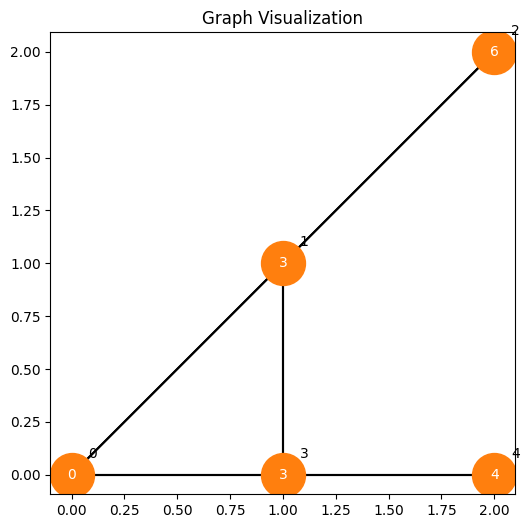

In [ ]:
graph_obj = GraphWithAttributes()

# Print the graph data
graph_obj.print_graph()

# Plot the graph
fig, ax = plt.subplots(figsize=(6, 6))
graph_obj.plot_graph(ax)
plt.show()

b) Write a GNN message passing layer, gnn1, that outputs:

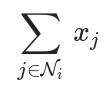

In [180]:
class gnn1(MessagePassing):
    def __init__(self, aggr='sum'):
        super().__init__(aggr=aggr)  # use sum aggregation method
    def forward(self, x, edge_index):
        return self.propagate(edge_index, x=x)

    def message(self, x_j):
        return x_j  # Pass the neighbor features as the message

    def update(self, aggr_out):
        return aggr_out  # Directly return the aggregated result

Apply the messaging layer to graph_w_attributes

In [188]:
custom_message_passing = gnn1(aggr='sum')  # Use sum aggregation
graph_obj = GraphWithAttributes()

# Extract graph components
x = graph_obj.x  # Node features
edge_index = graph_obj.edge_index  # Edge indices

# Perform message passing
updated_x = custom_message_passing(x, edge_index)

print("Original Node Features (x):")
print(x)

print("\nUpdated Node Features after Message Passing:")
print(updated_x)


Original Node Features (x):
tensor([[0.],
        [3.],
        [6.],
        [3.],
        [4.]])

Updated Node Features after Message Passing:
tensor([[6.],
        [9.],
        [3.],
        [7.],
        [3.]])


This checks out!

6.2 Message, attribute update

d) Use the GNN layer to update the node attributes according to:

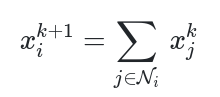

and e) Make a 2nd update:

In [ ]:
# Update the node attributes in the existing graph
graph_obj.x = updated_x

# Access the updated graph
print(graph_obj)

# Instantiate the CustomMessagePassing layer
custom_message_passing = gnn1(aggr='sum')  # Use sum aggregation

# Extract graph components
x = updated_x
edge_index = graph_obj.edge_index  # Edge indices

# Perform message passing
updated_x = custom_message_passing(x, edge_index)

print("Original Node Features (x):")
print(x)

print("\nUpdated Node Features after Message Passing:")
print(updated_x)


Data(x=[5, 1], edge_index=[2, 10], pos=[5, 2])
Original Node Features (x):
tensor([[6.],
        [9.],
        [3.],
        [7.],
        [3.]])

Updated Node Features after Message Passing:
tensor([[16.],
        [16.],
        [ 9.],
        [18.],
        [ 7.]])


f) Add self-loops

In [197]:
graph_obj.add_self_loops

# Verify the updated edge_index
print("Edge index with self-loops:")
print(graph_obj.edge_index)


Edge index with self-loops:
tensor([[0, 1, 1, 2, 1, 3, 0, 3, 3, 4],
        [1, 0, 2, 1, 3, 1, 3, 0, 4, 3]])


 and repeat d) and e).

In [203]:
custom_message_passing = gnn1(aggr='sum')  # Use sum aggregation
graph_obj = GraphWithAttributes()
graph_obj.add_self_loops()  # This modifies graph_obj.graph.edge_index

# Extract graph components from the updated graph
x = graph_obj.graph.x  # Node features
edge_index = graph_obj.graph.edge_index  # Updated edge indices (with self-loops)

# Perform message passing
updated_x = custom_message_passing(x, edge_index)

print("Original Node Features (x):")
print(x)

print("\nUpdated Node Features after Message Passing:")
print(updated_x)


Original Node Features (x):
tensor([[0.],
        [3.],
        [6.],
        [3.],
        [4.]])

Updated Node Features after Message Passing:
tensor([[ 6.],
        [12.],
        [ 9.],
        [10.],
        [ 7.]])


This checks out (look at my graph visualization above)

6.4 Aggregation with max
g) Repeat f), where the GNN layer implements:

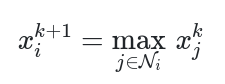

In [204]:
custom_message_passing = gnn1(aggr='max')  # NOW USING MAX INSTEAD OF SUM!
graph_obj = GraphWithAttributes()

# Extract graph components
x = graph_obj.x  # Node features
edge_index = graph_obj.edge_index  # Edge indices

# Perform message passing
updated_x = custom_message_passing(x, edge_index)

print("Original Node Features (x):")
print(x)

print("\nUpdated Node Features after Message Passing:")
print(updated_x)


Original Node Features (x):
tensor([[0.],
        [3.],
        [6.],
        [3.],
        [4.]])

Updated Node Features after Message Passing:
tensor([[3.],
        [6.],
        [3.],
        [4.],
        [3.]])


This checks out.

6.5 Big graph

g) Make a random graph with very many nodes and connections. All nodes have self-loops.

Here is a class that can make a big random graph which doesn't initially have self-loops.

In [219]:
class RandomGraphWithAttributes:
    def __init__(self, num_nodes):
        # Generate graph components using the given function
        edge_index, positions, x = elements_for_random_graph(num_nodes)
        
        # Create the PyTorch Geometric graph
        self.graph = Data(x=x.unsqueeze(1), edge_index=edge_index, pos=positions)

    def add_self_loops(self):
        from torch_geometric.utils import add_self_loops
        self.graph.edge_index, _ = add_self_loops(self.graph.edge_index)

    def plot_graph(self, ax=None):        
        if ax is None:
            fig, ax = plt.subplots(figsize=(8, 8))

        # Plot the nodes
        for idx, pos in enumerate(self.graph.pos):
            ax.scatter(pos[0], pos[1], c='C1', s=500)  # Draw the nodes
            ax.text(pos[0], pos[1], f'{int(self.graph.x[idx].item())}', color='w', ha='center', va='center')  # Node values
            ax.text(pos[0] + 0.2, pos[1] + 0.2, f'{idx}', color='black', ha='center', va='center')  # Node indices
        
        # Plot the edges
        for i1, i2 in self.graph.edge_index.T:
            ax.plot([self.graph.pos[i1, 0], self.graph.pos[i2, 0]], 
                    [self.graph.pos[i1, 1], self.graph.pos[i2, 1]], c='black', zorder=0)

        ax.axis('equal')
        ax.set_title("Random Graph Visualization")

    def print_graph(self):
        """
        Print the graph structure.
        """
        print("Graph Data:")
        print(self.graph)

Make a random big-ass graph with attributes and long connections. Still no self-loop.

Graph Data:
Data(x=[25, 1], edge_index=[2, 625], pos=[25, 2])


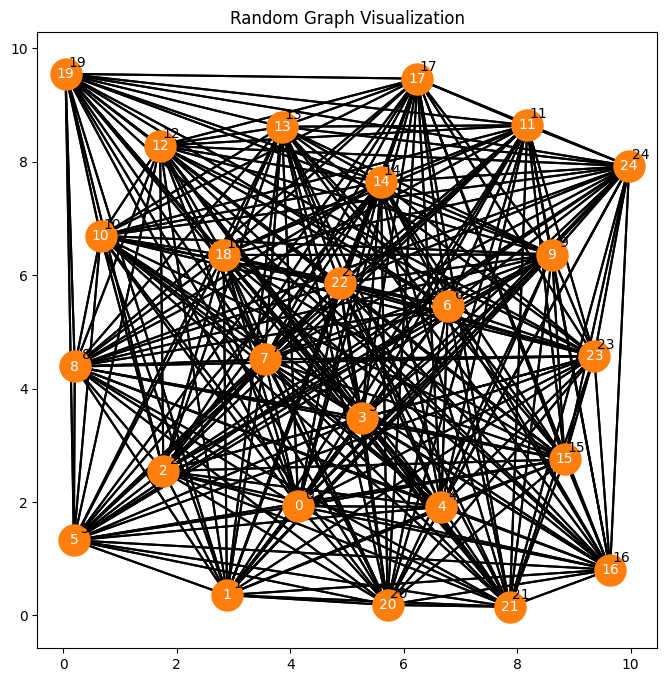

In [220]:
random_graph = RandomGraphWithAttributes(25)

# Print graph data
random_graph.print_graph()

# Plot
fig, ax = plt.subplots(figsize=(8, 8))
random_graph.plot_graph(ax)
plt.show()

Exclude nodes that are too far apart using keep_short_edges()

Graph Data:
Data(x=[25, 1], edge_index=[2, 103], pos=[25, 2])


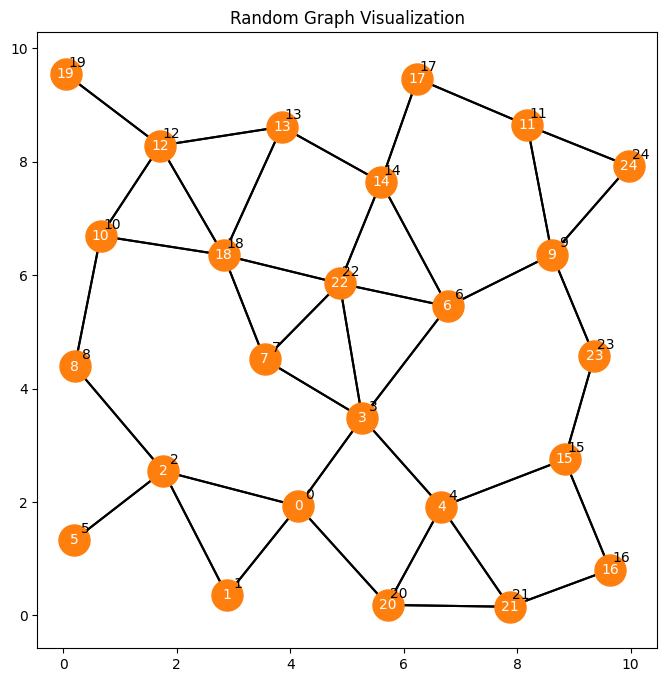

In [221]:
# Extract edge_index and positions from the graph
edge_index = random_graph.graph.edge_index
positions = random_graph.graph.pos

# Apply the keep_short_edges function to filter edges
filtered_edge_index = keep_short_edges(edge_index, positions)

# Update the graph with the filtered edges
random_graph.graph.edge_index = filtered_edge_index

# Print the updated graph
random_graph.print_graph()

# plot
fig, ax = plt.subplots(figsize=(8, 8))
random_graph.plot_graph(ax)
plt.show()


Add self-loops.

In [223]:
random_graph.add_self_loops() 

Repeat g) a number of times and see how information propagates with the messages.

In [225]:
custom_message_passing = gnn1(aggr='max')  # NOW USING MAX INSTEAD OF SUM!

# Extract graph components
x = random_graph.graph.x  # Node features
edge_index = random_graph.graph.edge_index  # Edge indices

# Perform message passing
updated_x = custom_message_passing(x, edge_index)

print("Original Node Features (x):")
print(x)

print("\nUpdated Node Features after Message Passing:")
print(updated_x)


Original Node Features (x):
tensor([[ 0.],
        [ 1.],
        [ 2.],
        [ 3.],
        [ 4.],
        [ 5.],
        [ 6.],
        [ 7.],
        [ 8.],
        [ 9.],
        [10.],
        [11.],
        [12.],
        [13.],
        [14.],
        [15.],
        [16.],
        [17.],
        [18.],
        [19.],
        [20.],
        [21.],
        [22.],
        [23.],
        [24.]])

Updated Node Features after Message Passing:
tensor([[20.],
        [ 2.],
        [ 8.],
        [22.],
        [21.],
        [ 5.],
        [22.],
        [22.],
        [10.],
        [24.],
        [18.],
        [24.],
        [19.],
        [18.],
        [22.],
        [23.],
        [21.],
        [17.],
        [22.],
        [19.],
        [21.],
        [21.],
        [22.],
        [23.],
        [24.]])


It seems to check out if I compare with the above graph.

Exercise 61

7.1 Trainable GNNs

This exercise is about setting up various GNNs and train their free parameters to predict some properties on the graphs. The properties will be either the node-wise number of nearest neighbors, or the graph-wise number of edges.

The exercise uses these graphs:

In [257]:
g0 = Data(edge_index=torch.tensor([
    [0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 4, 4],
    [0, 1, 3, 0, 1, 2, 1, 2, 4, 0, 3, 2, 4]]), pos=torch.tensor([[4.963, 7.682],
    [3.074, 6.341],[3.489, 4.017],[6.977, 8.   ],[1.61 , 2.823]],dtype=torch.float32),
    y=torch.tensor([2, 2, 2, 1, 1.],dtype=torch.float32).view(-1,1), x=torch.ones(5,1))
g1 = Data(edge_index=torch.tensor([
    [0, 0, 0, 0, 1, 1, 2, 2, 2, 3, 3, 4, 4],
    [0, 1, 2, 3, 0, 1, 0, 2, 4, 0, 3, 2, 4]]), pos=torch.tensor([[4.963, 4.012],
    [6.806, 5.142],[4.431, 6.432],[5.159, 1.636],[1.955, 6.691]], dtype=torch.float32),
    y=torch.tensor([3, 1, 2, 1, 1.],dtype=torch.float32).view(-1,1), x=torch.ones(5,1))
g2 = Data(edge_index=torch.tensor([
    [0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 4, 4],
    [0, 1, 2, 3, 0, 1, 2, 0, 1, 2, 3, 4, 0, 2, 3, 2, 4]]), pos=torch.tensor([[7.698, 7.945],
    [5.712, 7.06 ],[7.608, 5.876],[9.736, 6.541],[6.81 , 3.582]], dtype=torch.float32),
    y=torch.tensor([3, 2, 4, 2, 1.],dtype=torch.float32).view(-1,1), x=torch.ones(5,1))
g3 = Data(edge_index=torch.tensor([
    [0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4],
    [0, 1, 2, 0, 1, 4, 0, 2, 3, 2, 3, 4, 1, 3, 4]]), pos=torch.tensor([[4.488, 7.382],
    [5.241, 9.701],[5.269, 5.412],[7.128, 6.766],[7.317, 8.692]], dtype=torch.float32),
    y=torch.tensor([2, 2, 2, 2, 2.],dtype=torch.float32).view(-1,1), x=torch.ones(5,1))
g4 = Data(edge_index=torch.tensor([
    [0, 0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4],
    [0, 1, 2, 3, 4, 0, 1, 4, 0, 2, 3, 0, 2, 3, 0, 1, 4]]), pos=torch.tensor([[2.753, 8.131],
    [0.719, 7.519],[5.007, 7.139],[4.68 , 9.057],[1.645, 9.674]], dtype=torch.float32),
    y=torch.tensor([4, 2, 2, 2, 2.],dtype=torch.float32).view(-1,1), x=torch.ones(5,1))
g5 = Data(edge_index=torch.tensor([
    [0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 4, 4, 4],
    [0, 1, 0, 1, 2, 4, 1, 2, 3, 4, 2, 3, 1, 2, 4]]), pos=torch.tensor([[4.554, 1.77 ],
    [3.023, 3.16 ],[1.27 , 4.22 ],[0.436, 6.327],[0.976, 1.79 ]], dtype=torch.float32),
    y=torch.tensor([0, 0, 0, 0, 0.],dtype=torch.float32).view(-1,1), x=torch.ones(5,1))

Method for plotting.

In [232]:
from matplotlib.cm import get_cmap
from torch_geometric.data import Data

def plot_graph_with_y_colored(ax, graph, title):
    """
    Plot a graph and color nodes based on their y attributes.
    
    Args:
        ax: Matplotlib axis to plot on.
        graph: PyTorch Geometric Data object representing the graph.
        title: Title for the subplot.
    """
    cmap = get_cmap("viridis")  # Use the 'viridis' colormap for node colors

    # Normalize y values for coloring
    y_min, y_max = graph.y.min().item(), graph.y.max().item()
    y_normalized = (graph.y - y_min) / (y_max - y_min) if y_max > y_min else graph.y

    # Plot nodes with colors
    for idx, pos in enumerate(graph.pos):
        y_value = graph.y[idx].item()  # Extract y value for the node
        color = cmap(y_normalized[idx].item())  # Map normalized y to a color
        ax.scatter(pos[0], pos[1], c=[color], s=500)  # Draw the node with the color
        ax.text(pos[0], pos[1], f'{y_value:.0f}', color='w', ha='center', va='center', fontsize=10)  # y attribute
        ax.text(pos[0] + 0.3, pos[1] + 0.3, f'{idx}', color='black', ha='center', va='center', fontsize=8)  # Node index
    
    # Plot edges
    for i1, i2 in graph.edge_index.T:
        ax.plot([graph.pos[i1, 0], graph.pos[i2, 0]], 
                [graph.pos[i1, 1], graph.pos[i2, 1]], c='black', zorder=0)

    # Add title and margins
    ax.set_title(title, fontsize=12)
    ax.axis('equal')
    ax.axis('off')

Plot the six graphs using above class.

/tmp/ipykernel_159397/2352163800.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("viridis")  # Use the 'viridis' colormap for node colors


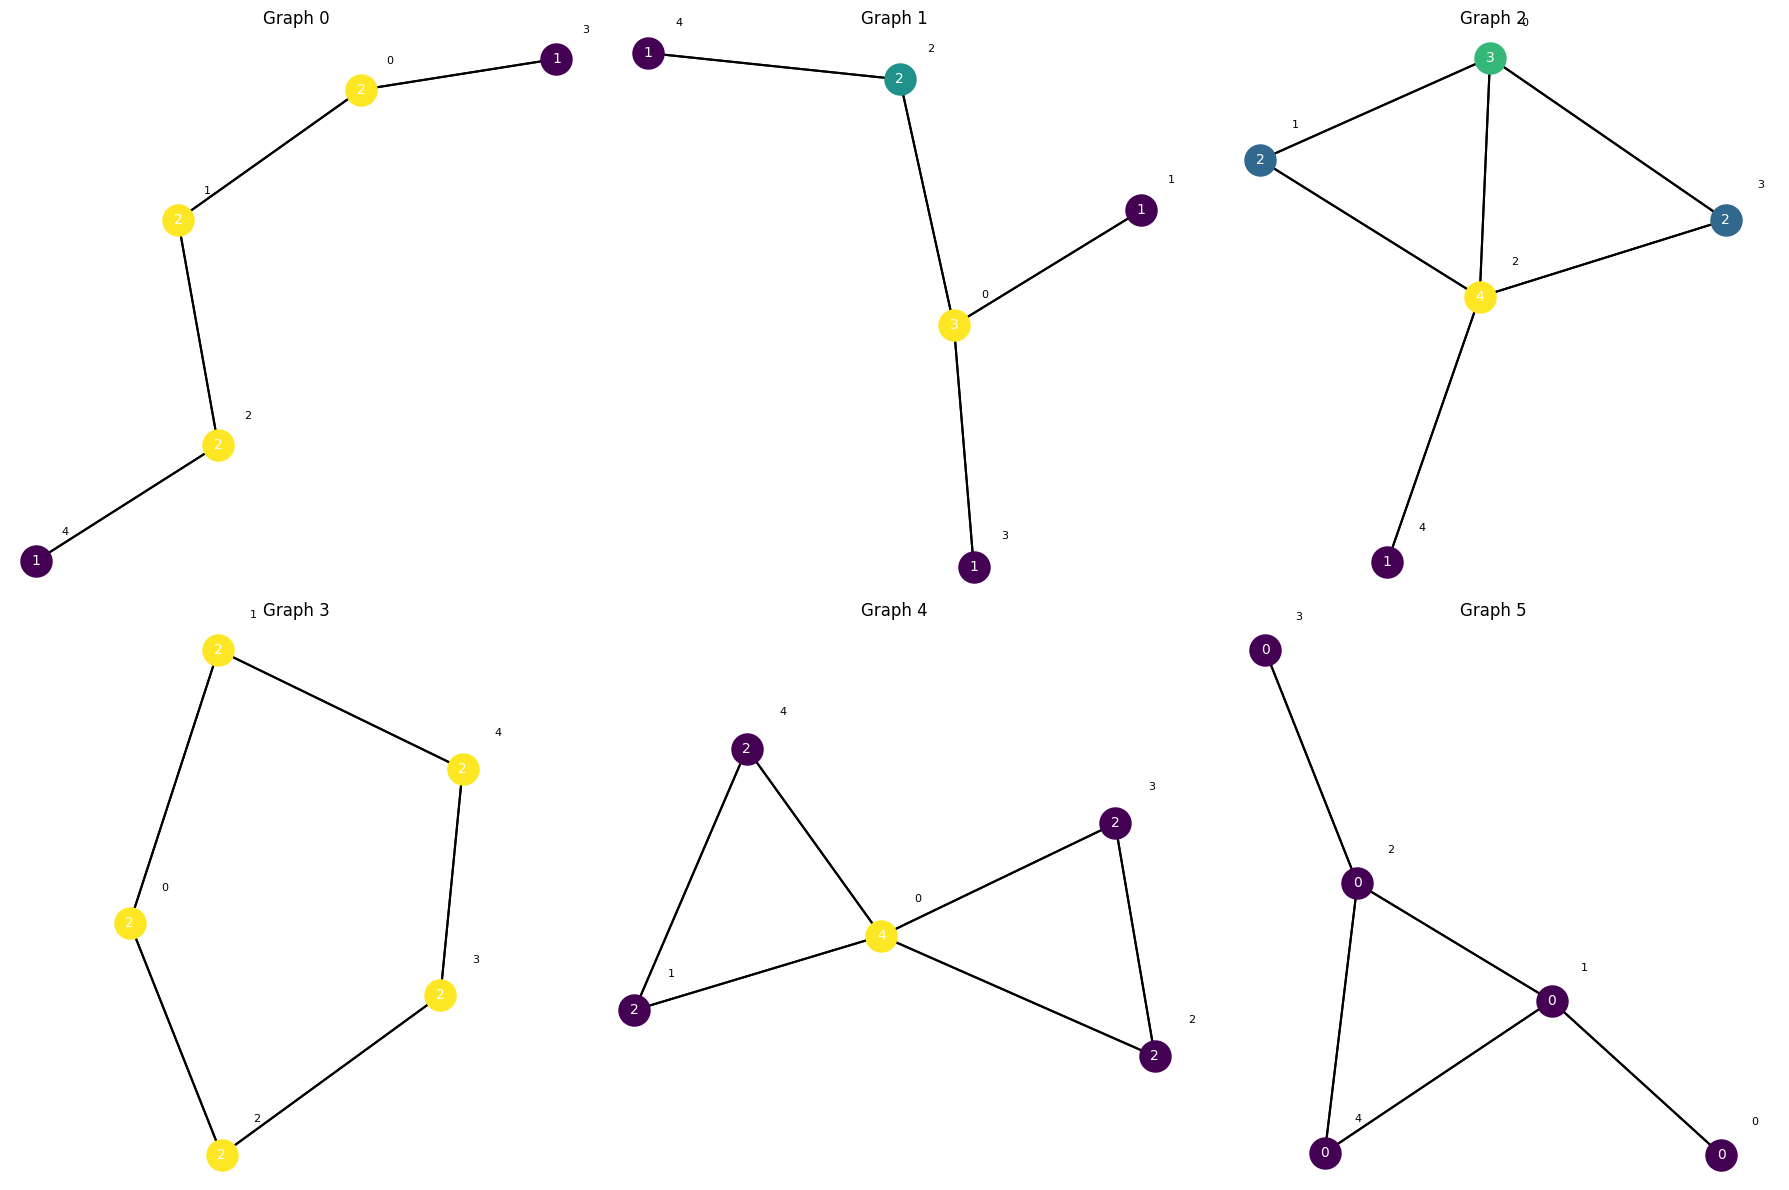

In [258]:
# List of graphs
graphs = [g0, g1, g2, g3, g4, g5]

# Create a figure with subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))  # Larger figure size for clarity
axes = axes.flatten()

# Plot each graph
for i, graph in enumerate(graphs):
    plot_graph_with_y_colored(axes[i], graph, title=f'Graph {i}')

# Adjust layout
plt.tight_layout()
plt.show()


7.2 Parameter-free model

b) Introduce a GNN layer according to:

In [236]:
class NoParamsGNN(MessagePassing):
    def __init__(self,aggr='add'):
        super().__init__(aggr=aggr)

    def forward(self, x, edge_index):
        return self.propagate(edge_index, x=x)

    def message(self, x_j): 
        return x_j

and wrap it in a model, that takes a graph as its input:

In [246]:
no_params_gnn = NoParamsGNN()
model = lambda graph: no_params_gnn(graph.x, graph.edge_index)

c) Show that using this model, you get the following model-predictions for the test-graph:

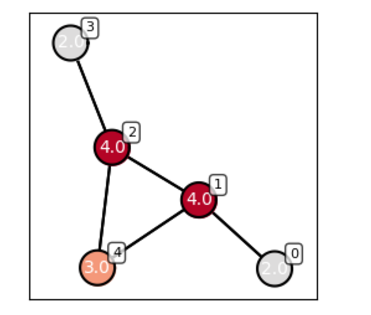

which aren't exactly the the number of nearest neighbours. We need a better model!

In [245]:
modelled_sixth_graph = model(g5)
modelled_sixth_graph

tensor([[2.],
        [4.],
        [4.],
        [2.],
        [3.]])

/tmp/ipykernel_159397/3578622716.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("viridis")  # Use 'viridis' colormap for coloring


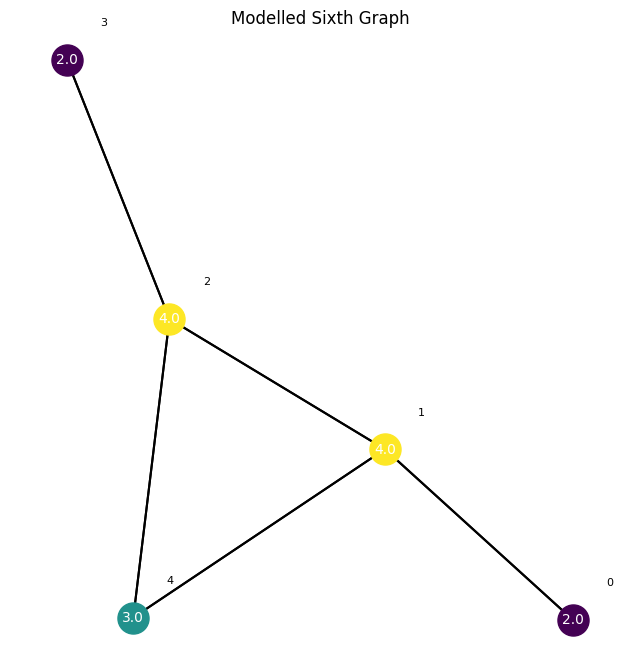

In [ ]:
def plot_graph_with_attributes(ax, graph, attributes, title):
    # Normalize the attributes for coloring
    attr_min, attr_max = attributes.min().item(), attributes.max().item()
    normalized_attrs = (attributes - attr_min) / (attr_max - attr_min) if attr_max > attr_min else attributes

    cmap = get_cmap("viridis")  # Use 'viridis' colormap for coloring

    # Plot nodes
    for idx, pos in enumerate(graph.pos):
        attr_value = attributes[idx].item()  # Get the attribute for the node
        color = cmap(normalized_attrs[idx].item())  # Map normalized value to color
        ax.scatter(pos[0], pos[1], c=[color], s=500)  # Draw the node
        ax.text(pos[0], pos[1], f'{attr_value:.1f}', color='w', ha='center', va='center', fontsize=10)  # Display attribute
        ax.text(pos[0] + 0.3, pos[1] + 0.3, f'{idx}', color='black', ha='center', va='center', fontsize=8)  # Display index
    
    # Plot edges
    for i1, i2 in graph.edge_index.T:
        ax.plot([graph.pos[i1, 0], graph.pos[i2, 0]], 
                [graph.pos[i1, 1], graph.pos[i2, 1]], c='black', zorder=0)

    # Add title
    ax.set_title(title, fontsize=12)
    ax.axis('equal')
    ax.axis('off')

# Plot the sixth graph with the updated attributes
fig, ax = plt.subplots(figsize=(8, 8))
plot_graph_with_attributes(ax, g5, modelled_sixth_graph, title="Modelled Sixth Graph")
plt.show()


This is correct, but the coding is hella ugly.

7.3 GNN with ψ

d) Now introduce a linear transformation, ψ, on the message being sent. I.e. implement:

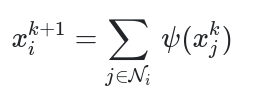

where ψ is given by one neuron.

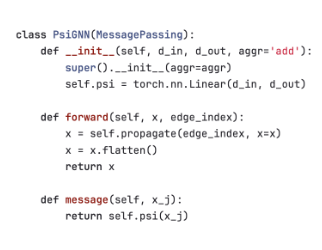

In [308]:
import torch
import torch.nn as nn
from torch_geometric.nn import MessagePassing
import torch.optim as optim
import matplotlib.pyplot as plt
class PsiGNN(MessagePassing):
    def __init__(self, d_in, d_out, aggr='add'):
        super().__init__(aggr=aggr)
        self.psi = nn.Linear(d_in, d_out)  # Learnable linear transformation

    def forward(self, graph):
        x, edge_index = graph.x, graph.edge_index  # Extract x and edge_index
        x = self.propagate(edge_index, x=x)
        return x.flatten()

    def message(self, x_j):
        return self.psi(x_j)


Training

In [313]:
import torch
import torch.nn as nn
from torch_geometric.nn import MessagePassing
import torch.optim as optim

# All graphs
all_graphs = [g0, g1, g2, g3, g4, g5]
train_graphs = all_graphs[:5]  # First 5 graphs for training
test_graph = all_graphs[5]     # Sixth graph for testing

# Initialize the model
psi_gnn = PsiGNN(d_in=1, d_out=1)  # Input and output dimensions both 1

# Define the optimizer and loss function
learning_rate = 0.001
optimizer = torch.optim.Adam(psi_gnn.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

# Training loop
epochs = 2500
model = psi_gnn

print(f"Weight: {psi_gnn.psi.weight}")
print(f"Bias: {psi_gnn.psi.bias}")


for epoch in range(epochs):
    total_loss = 0
    for graph in train_graphs:
        optimizer.zero_grad() 
        prediction = model(graph)
        loss = criterion(prediction, graph.y.flatten())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_graphs)
    if (epoch + 1) % 250 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")


Weight: Parameter containing:
tensor([[0.6299]], requires_grad=True)
Bias: Parameter containing:
tensor([-0.7517], requires_grad=True)
Epoch 250/2500, Loss: 0.0664
Epoch 500/2500, Loss: 0.0664
Epoch 750/2500, Loss: 0.0664
Epoch 1000/2500, Loss: 0.0664
Epoch 1250/2500, Loss: 0.0664
Epoch 1500/2500, Loss: 0.0665
Epoch 1750/2500, Loss: 0.0665
Epoch 2000/2500, Loss: 0.0665
Epoch 2250/2500, Loss: 0.0665
Epoch 2500/2500, Loss: 0.0665


In [314]:
print(f"Weight: {psi_gnn.psi.weight}")
print(f"Bias: {psi_gnn.psi.bias}")


Weight: Parameter containing:
tensor([[1.0353]], requires_grad=True)
Bias: Parameter containing:
tensor([-0.3463], requires_grad=True)


7.4 DataLoader

f) Repeat e), but this time keep the five training graphs in a Dataloader.



We use the DataLoader from torch_geometric to batch the training graphs:

In [ ]:
from torch_geometric.loader import DataLoader

# Create a DataLoader for the training graphs
train_graphs = [g0, g1, g2, g3, g4]  # Training graphs
loader = DataLoader(train_graphs, batch_size=5, shuffle=True)  # Batch all graphs together